In [57]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
titanic = pd.read_csv('./Titanic.csv')

# Display the first few rows of the dataframe
titanic.head()

,Unnamed: 0,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1st,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.337494,B5,Southampton,2,NaN,"St Louis, MO"
1,2,1st,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.550003,C22 C26,Southampton,11,NaN,"Montreal, PQ / Chesterville, ON"
2,3,1st,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,4,1st,0,"Allison, Mr. Hudson Joshua Crei",male,30.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,5,1st,0,"Allison, Mrs. Hudson J C (Bessi",female,25.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"


# Step 1

In [58]:
def QuantileBinning(feature, bin_number):
    """
    This function takes a numerical feature and the number of bins, and
    returns the feature binned into quantile-based bins.

    Parameters:
    - feature (pandas.Series): The numerical feature to be binned.
    - bin_number (int): The number of quantile bins.

    Returns:
    - pandas.Series: A series of discrete features binned by quantile.
    """
    # Use qcut to create quantile-based bins for the feature
    # If there are fewer unique values than bins, qcut could throw an error.
    # 'duplicates' parameter handles this by dropping redundant bins.
    return pd.qcut(feature, q=bin_number, labels=False, duplicates='drop')

# One example
feature_test = pd.DataFrame(np.random.rand(100),  columns=['Column_A'])
feature_test_discrete = QuantileBinning(feature_test['Column_A'], 10)

def label_encoder(feature):
    unique_labels = pd.unique(feature)
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
    transformed_feature = np.array([label_to_int[label] for label in feature])
    return transformed_feature

In [59]:
# Fill missing values in 'age' with the average age
titanic['age'] = titanic['age'].fillna(titanic['age'].mean())

# Discretization
titanic['survived'] = label_encoder(titanic['survived'])
titanic['pclass'] = label_encoder(titanic['pclass'])
titanic['sibsp'] = label_encoder(titanic['sibsp'])
titanic['sex'] = label_encoder(titanic['sex'])

titanic['age'] = QuantileBinning(titanic['age'], 10)


# Split the data into 80% training and 20% test sets
set = titanic[['pclass', 'sex', 'age', 'sibsp', 'survived']]
set = set.sample(frac=1) 
split = int(0.8 * set.shape[0])
training = set[:split]
testing = set[split:]

In [60]:
training.head()

,pclass,sex,age,sibsp,survived
292,0,1,7,1,0
535,1,1,7,0,1
1125,2,1,2,0,1
1090,2,0,2,0,1
1139,2,1,6,0,1


# Step 2

In [61]:
# define your entropy function and information gain function
def entropy(feature):
    """
    This function calculates the entropy of a feature.

    Parameters:
    - feature (pandas.Series): The feature for which to calculate the entropy.

    Returns:
    - float: The entropy of the feature.
    """
    # Calculate the frequency of each unique value in the feature
    value_counts = feature.value_counts()
    # Calculate the probability of each unique value
    probabilities = value_counts / len(feature)
    # Calculate the entropy of the feature
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

# Calculate Information Gain for each feature in the training set
def information_gain(data, feature_name, target_name):
    """
    This function calculates the information gain of a feature in a dataset.

    Parameters:
    - data (pandas.DataFrame): The dataset containing the feature and target.
    - split_name (str): The name of the feature for which to calculate information gain.
    - target_name (str): The name of the target feature.

    Returns:
    - float: The information gain of the feature.
    """
    # Calculate the entropy of the dataset
    target_entropy = entropy(data[target_name])

   # Caculate the entropy of the feature
    feature_entropy = 0
    feature = data[feature_name]
    for value in feature.unique():
        set = data[data[feature_name] == value]
        feature_entropy += len(set) / len(data) * entropy(set[target_name])
    # Calculate the information gain of the split feature
    information_gain = target_entropy - feature_entropy
    return information_gain

# Format Information gain into a dictionary "info gains"
features = ['pclass', 'sex', 'age', 'sibsp']
info_gains = {}
for feature in features:
    info_gains[feature] = information_gain(training, feature, 'survived')


In [62]:
info_gains

{'pclass': 0.07845226472925515,
 'sex': 0.19845506029363613,
 'age': 0.022750697314514734,
 'sibsp': 0.025142429499852015}

So the first split should be "sex"

# Step 3

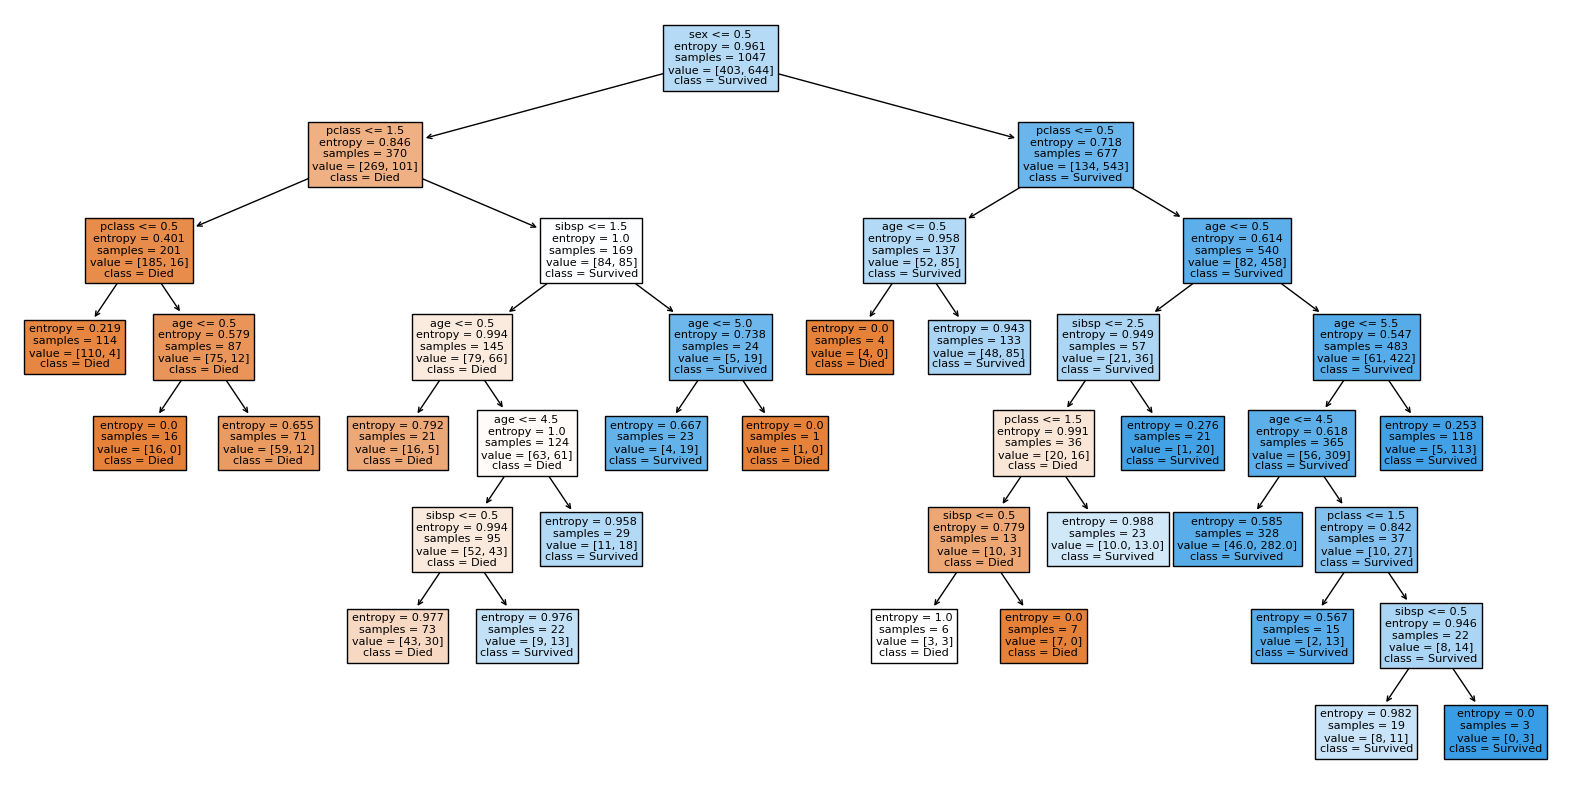

In [63]:
from sklearn.tree import DecisionTreeClassifier, plot_tree #sklearn.metrics is not imported !!!

# Instantiate the DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion='entropy', random_state=20011191, max_leaf_nodes = 20)

# Prepare the features and target variables for training
X_train = training.drop(columns='survived')
y_train = training['survived']


# Fit the decision tree model
dt.fit(X_train, y_train)

# Plot the full decision tree
plt.figure(figsize=(20,10))
plot_tree(dt, filled=True, feature_names=X_train.columns, class_names=['Died', 'Survived'])
plt.show()


In [64]:
# Define your performance metrics including accuracy, precision, recall and F1-scorre
def accuracy (y_true, y_pred):
    """
    This function calculates the accuracy of a model.

    Parameters:
    - y_true (numpy.array): The true labels.
    - y_pred (numpy.array): The predicted labels.

    Returns:
    - float: The accuracy of the model.
    """
    correct = np.sum(y_true == y_pred)
    total = len(y_true)
    return correct / total

def precision(y_true, y_pred):
    """
    This function calculates the precision of a model.

    Parameters:
    - y_true (numpy.array): The true labels.
    - y_pred (numpy.array): The predicted labels.

    Returns:
    - float: The precision of the model.
    """
    true_positive = np.sum((y_true == 1) & (y_pred == 1))
    false_positive = np.sum((y_true == 0) & (y_pred == 1))
    return true_positive / (true_positive + false_positive)

def recall(y_true, y_pred):
    """
    This function calculates the recall of a model.

    Parameters:
    - y_true (numpy.array): The true labels.
    - y_pred (numpy.array): The predicted labels.

    Returns:
    - float: The recall of the model.
    """
    true_positive = np.sum((y_true == 1) & (y_pred == 1))
    false_negative = np.sum((y_true == 1) & (y_pred == 0))
    return true_positive / (true_positive + false_negative)

def f1_score(y_true, y_pred):
    """
    This function calculates the F1 score of a model.

    Parameters:
    - y_true (numpy.array): The true labels.
    - y_pred (numpy.array): The predicted labels.

    Returns:
    - float: The F1 score of the model.
    """
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec)

# Prepare the features and target variables for testing
X_test = testing.drop(columns='survived')
y_test = testing['survived']

# Predict the target variable for the test set
y_pred = dt.predict(X_test)

# Calculate the performance metrics
acc = accuracy(y_test, y_pred)
prec = precision(y_test, y_pred)
rec = recall(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics in a dictionary
performance = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1 Score': f1}
performance

{'Accuracy': 0.8053435114503816,
 'Precision': 0.8097826086956522,
 'Recall': 0.9030303030303031,
 'F1 Score': 0.8538681948424071}

# Step 4

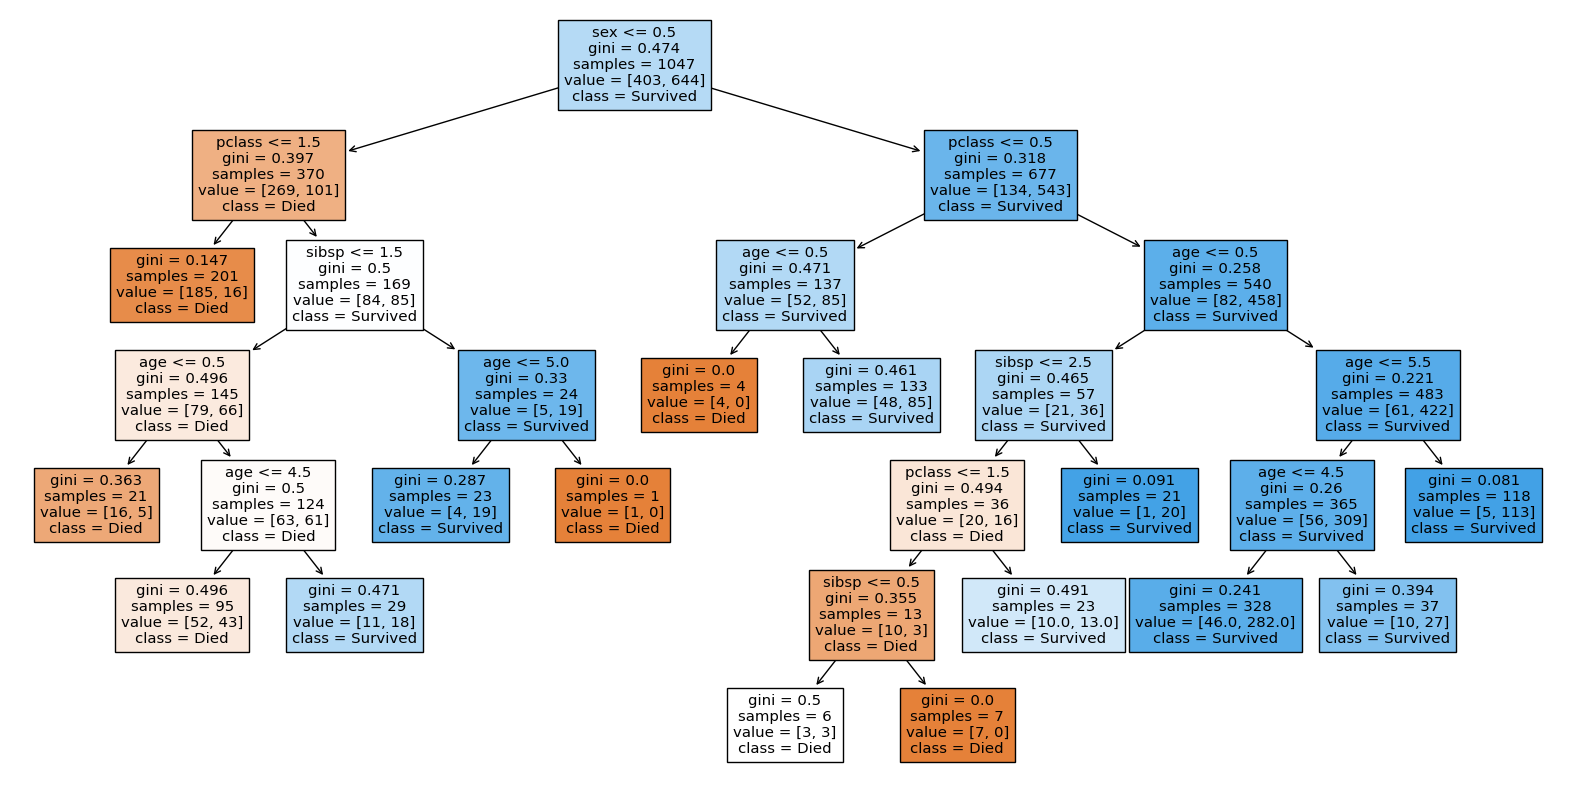

{'Accuracy': 0.8091603053435115,
 'Precision': 0.8248587570621468,
 'Recall': 0.8848484848484849,
 'F1 Score': 0.8538011695906432}

In [65]:
from sklearn.model_selection import GridSearchCV

# Define a range of max_leaf_nodes values to search
param_grid = {'max_leaf_nodes': list(range(5, 20))}

# Run grid search with cross-validation
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train) # Note testing set cannot be used

# Get the best estimator with the optimal max_leaf_nodes parameter
best_tree = grid_search.best_estimator_

# Plot the pruned decision tree
plt.figure(figsize=(20,10))
plot_tree(best_tree, filled=True, feature_names=X_train.columns, class_names=['Died', 'Survived'])
plt.show()

#Calculate the performance metrics for the best tree
y_pred = best_tree.predict(X_test)
acc = accuracy(y_test, y_pred)
prec = precision(y_test, y_pred)
rec = recall(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics in a dictionary
best_performance = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1 Score': f1}
best_performance

# Step 5


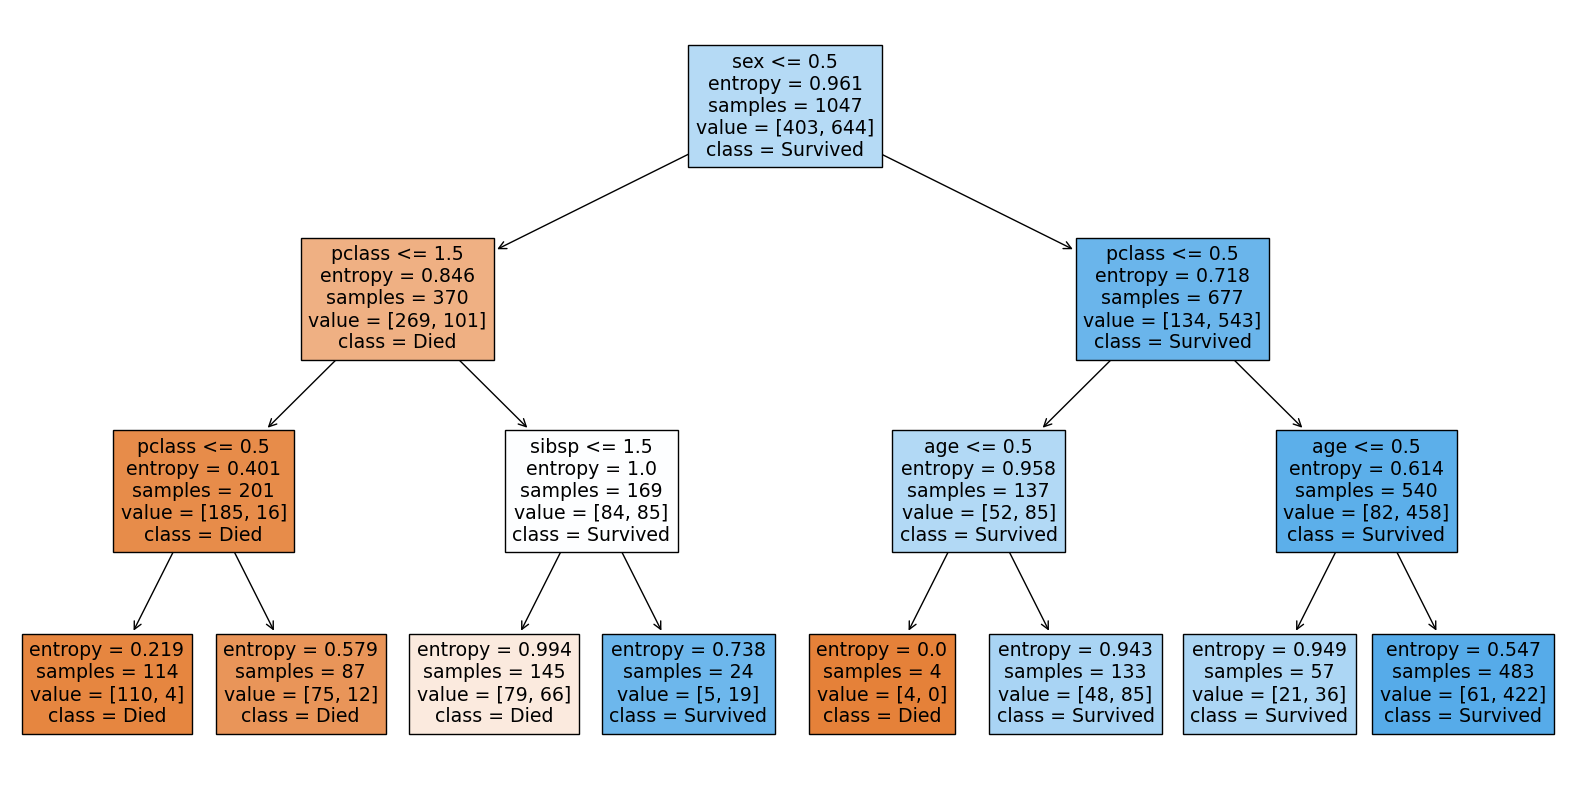

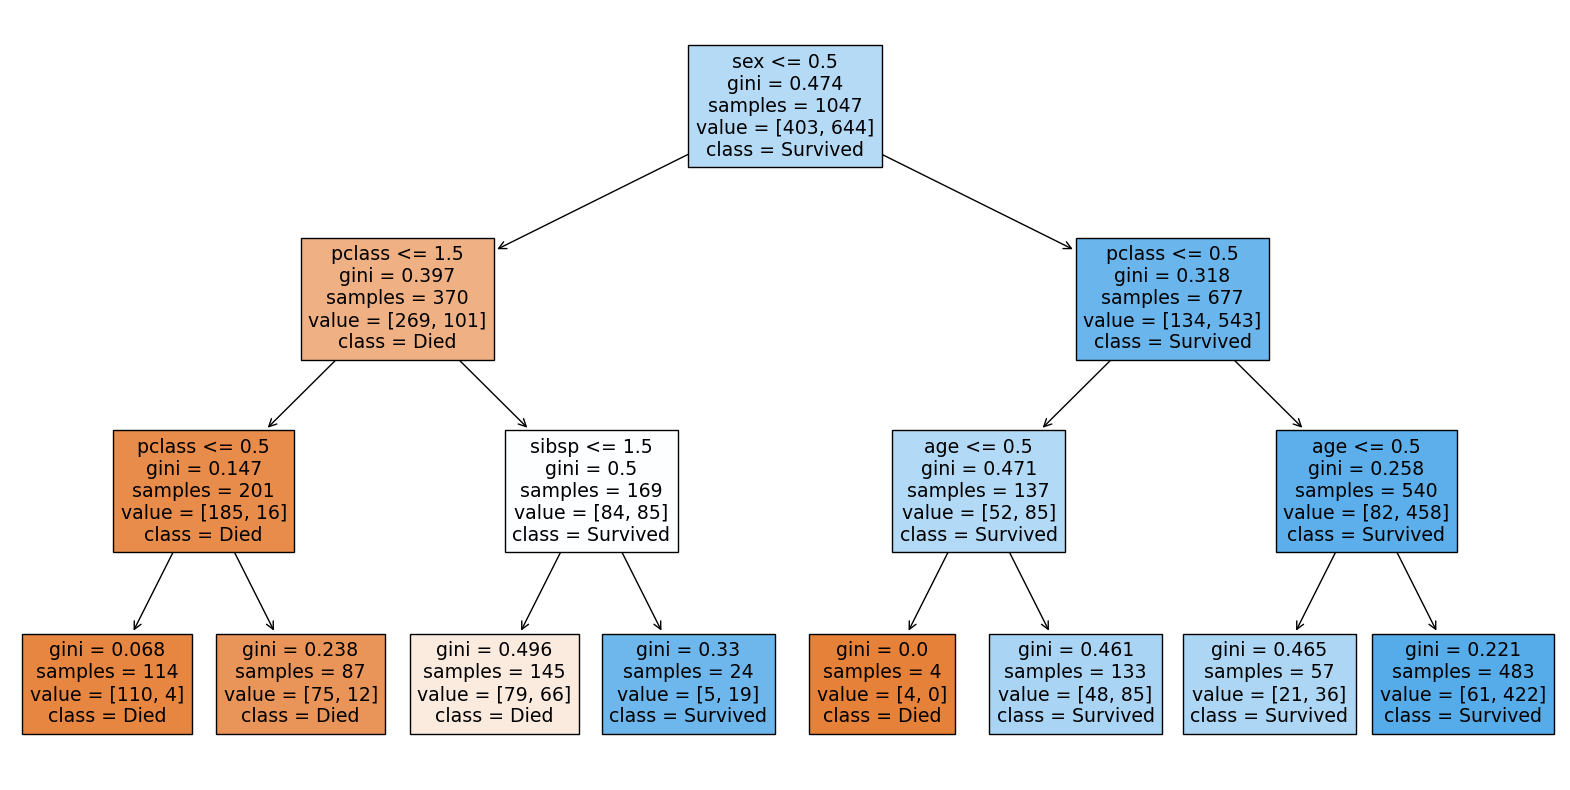

Max Depth Performance: {'Accuracy': 0.8015267175572519, 'Precision': 0.8304093567251462, 'Recall': 0.8606060606060606, 'F1 Score': 0.8452380952380952}
Opt Criteria Performance: {'Accuracy': 0.8015267175572519, 'Precision': 0.8304093567251462, 'Recall': 0.8606060606060606, 'F1 Score': 0.8452380952380952}


In [66]:
## it's an example (max_depth)
# Instantiate the DecisionTreeClassifier
dt_max_depth = DecisionTreeClassifier(criterion='entropy', random_state=20011191, max_depth = 3, max_leaf_nodes = 20)

# Fit the decision tree model
dt_max_depth.fit(X_train, y_train)

# Plot the full decision tree
plt.figure(figsize=(20,10))
plot_tree(dt_max_depth, filled=True, feature_names=X_train.columns, class_names=['Died', 'Survived'])
plt.show()

# Instantiate the DecisionTreeClassifier
dt_opt_criteria = DecisionTreeClassifier(criterion='gini', random_state=20011191, max_depth = 3, max_leaf_nodes = 20)

# Fit the decision tree model
dt_opt_criteria.fit(X_train, y_train)

# Plot the full decision tree
plt.figure(figsize=(20,10))
plot_tree(dt_opt_criteria, filled=True, feature_names=X_train.columns, class_names=['Died', 'Survived'])
plt.show()

# Calculate the performance metrics for the max depth tree
y_pred = dt_max_depth.predict(X_test)
acc = accuracy(y_test, y_pred)
prec = precision(y_test, y_pred)
rec = recall(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics in a dictionary
max_depth_performance = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1 Score': f1}
print('Max Depth Performance:', max_depth_performance)

#Calculate the performance metrics for the optimal criteria tree
y_pred = dt_opt_criteria.predict(X_test)
acc = accuracy(y_test, y_pred)
prec = precision(y_test, y_pred)
rec = recall(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics in a dictionary
opt_criteria_performance = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1 Score': f1}
print('Opt Criteria Performance:', opt_criteria_performance)



In [67]:
def ensemble_vote(models, X):

    # Perform majority vote
    # For each sample, count the votes for each class (0 or 1)
    ensemble_predictions = np.zeros((len(X), len(models)))
    for idx in range(len(models)):
        ensemble_predictions[:, idx] = models[idx].predict(X)
    # Determine the winning class for each sample: it's the one with the most votes
    # If there's a tie, we choose the class with the highest index (1 in this case)
    ensemble_predictions = np.apply_along_axis(lambda x: np.argmax(np.bincount(x.astype(int))), axis=1, arr=ensemble_predictions)

    return ensemble_predictions
# Use the defined function to get predictions from the ensemble of the three trees
models = [best_tree, dt_max_depth, dt_opt_criteria]
ensemble_predictions = ensemble_vote(models, X_test)

# Calculate performance metrics for the ensemble using the previously defined function
acc = accuracy(y_test, ensemble_predictions)
prec = precision(y_test, ensemble_predictions)
rec = recall(y_test, ensemble_predictions)
f1 = f1_score(y_test, ensemble_predictions)

#Print the performance metrics in a dictionary
ensemble_performance = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1 Score': f1}
ensemble_performance


{'Accuracy': 0.8015267175572519,
 'Precision': 0.8304093567251462,
 'Recall': 0.8606060606060606,
 'F1 Score': 0.8452380952380952}

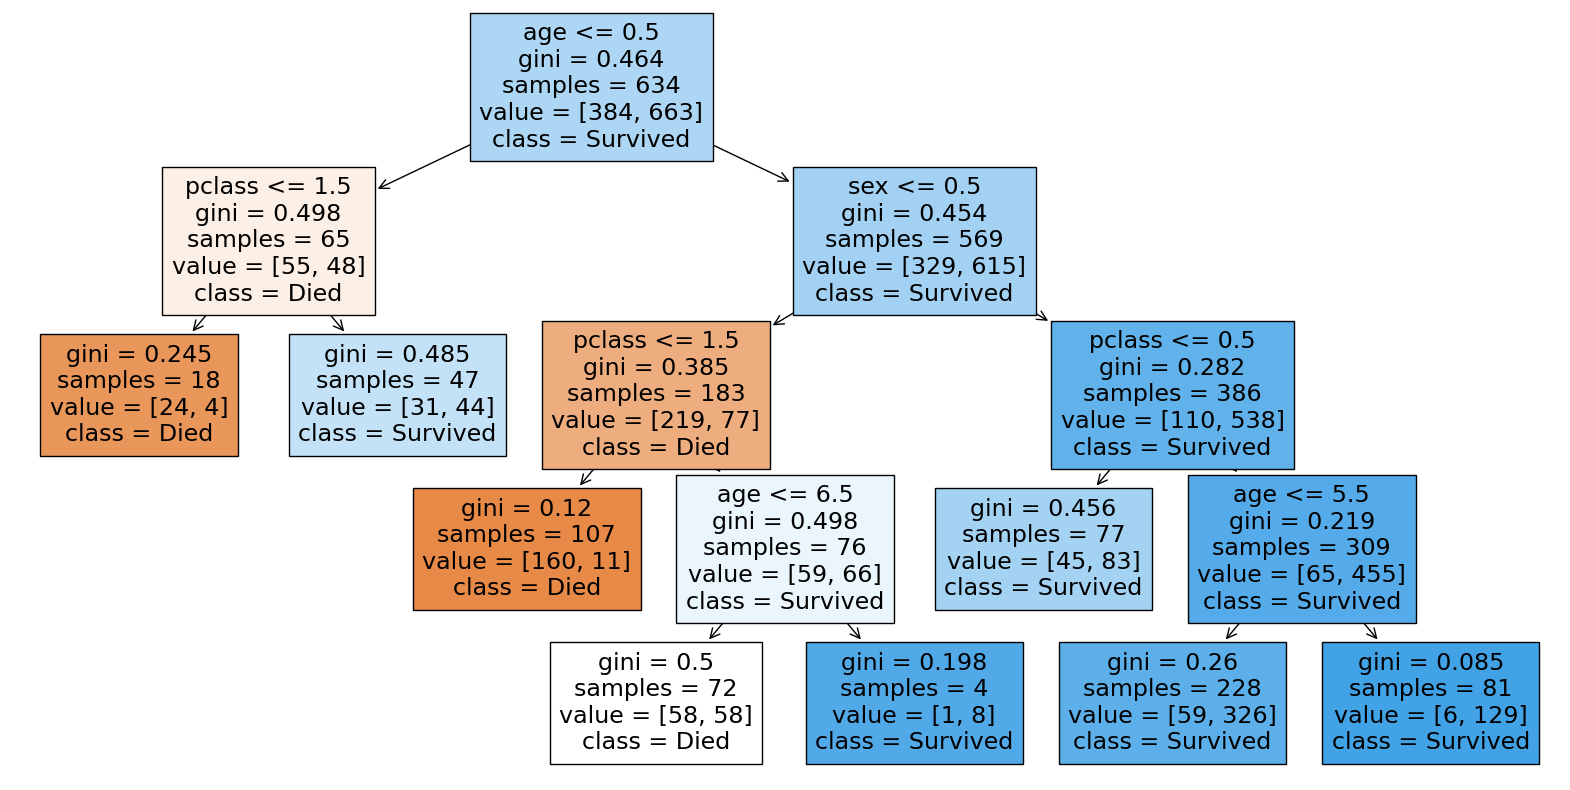

{'Accuracy': 0.8053435114503816,
 'Precision': 0.8352941176470589,
 'Recall': 0.8606060606060606,
 'F1 Score': 0.8477611940298508}

In [68]:
# Train a random forest model using the optimal tree you found in step 4 and compare the ensembled model with the random forest 
from sklearn.ensemble import RandomForestClassifier

# Instantiate the RandomForestClassifier with the optimized max depth of 4 from step 4
random_dt = RandomForestClassifier(n_estimators=50, random_state=20011191, max_depth=4, max_leaf_nodes=8)

# Fit the random forest model
random_dt.fit(X_train, y_train)

#Plot the tree
plt.figure(figsize=(20,10))
plot_tree(random_dt.estimators_[0], filled=True, feature_names=X_train.columns, class_names=['Died', 'Survived'])
plt.show()

#Calculate the performance metrics for the random forest
y_pred = random_dt.predict(X_test)
acc = accuracy(y_test, y_pred)
prec = precision(y_test, y_pred)
rec = recall(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

#Print the performance metrics in a dictionary
random_forest_performance = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1 Score': f1}
random_forest_performance

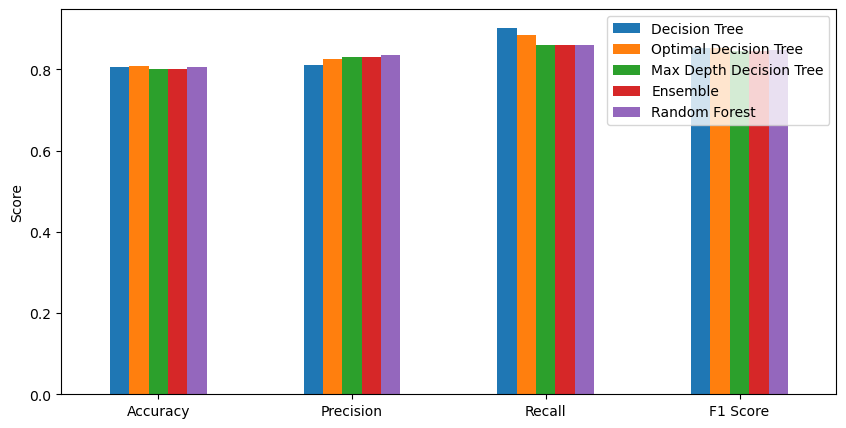

In [69]:
#Compare the performance of all the models using a bar graph with the the performance metrics as the x-axis and the model names as the y-axis

# Create a dataframe with the performance metrics
performance_df = pd.DataFrame([performance, best_performance, max_depth_performance, ensemble_performance, random_forest_performance]).T
performance_df.columns = ['Decision Tree', 'Optimal Decision Tree', 'Max Depth Decision Tree', 'Ensemble', 'Random Forest']

# Plot the performance metrics
performance_df.plot(kind='bar', figsize=(10,5))
plt.xticks(rotation=0)
plt.ylabel('Score')
plt.show()